In [1]:
import pandas as pd

df = pd.read_csv("/Users/darrelljarrett/Explainable Machine Learning for Diabetes Prediction/cleaned_brfss_2015.csv")
df.head()

,GENHLTH,BPHIGH4,CHOLCHK,TOLDHI2,DIABETE3,SEX,EDUCA,INCOME2,SMOKE100,EXERANY2,_AGEG5YR,_BMI5
0,5.0,1.0,1.0,1.0,3.0,2.0,4.0,3.0,1.0,2.0,10.0,40.18
1,3.0,3.0,4.0,2.0,3.0,2.0,6.0,1.0,1.0,1.0,10.0,25.09
2,4.0,3.0,1.0,1.0,3.0,2.0,4.0,8.0,2.0,1.0,11.0,22.04
3,5.0,1.0,1.0,1.0,3.0,2.0,4.0,8.0,2.0,2.0,10.0,28.19
4,5.0,3.0,1.0,2.0,3.0,2.0,5.0,8.0,2.0,2.0,10.0,24.37


In [2]:
df = df[df['DIABETE3'].isin([1, 3])]  # Keep only "Yes" (1) and "No" (3)
df['diabetes_binary'] = df['DIABETE3'].map({1: 1, 3: 0})
df = df.drop(columns=['DIABETE3'])
df.head()

,GENHLTH,BPHIGH4,CHOLCHK,TOLDHI2,SEX,EDUCA,INCOME2,SMOKE100,EXERANY2,_AGEG5YR,_BMI5,diabetes_binary
0,5.0,1.0,1.0,1.0,2.0,4.0,3.0,1.0,2.0,10.0,40.18,0
1,3.0,3.0,4.0,2.0,2.0,6.0,1.0,1.0,1.0,10.0,25.09,0
2,4.0,3.0,1.0,1.0,2.0,4.0,8.0,2.0,1.0,11.0,22.04,0
3,5.0,1.0,1.0,1.0,2.0,4.0,8.0,2.0,2.0,10.0,28.19,0
4,5.0,3.0,1.0,2.0,2.0,5.0,8.0,2.0,2.0,10.0,24.37,0


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(columns=['diabetes_binary'])
y = df['diabetes_binary']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict
y_pred = rf.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8499375517969908
Precision: 0.39619129438717066
Recall: 0.2425916184464317
F1 Score: 0.30092441544317566


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, classification_report

# Class balance/ Calculates the prevalence of the positive class in the test set 
pos_rate = y_test.mean()
print(f"Positive rate (prevalence): {pos_rate:.4f}")

# AUCs Gets the model’s predicted probability that each person is positive (diabetes).
y_prob = rf.predict_proba(X_test)[:,1]

#probability the model ranks a randomly chosen positive higher than a randomly chosen negative. 
print("ROC AUC:", roc_auc_score(y_test, y_prob)) 

#area under the precision–recall curve
print("PR AUC :", average_precision_score(y_test, y_prob))

# Confusion matrix at default 0.5 threshold
print(confusion_matrix(y_test, (y_prob>=0.5).astype(int)))

# Full report
print(classification_report(y_test, (y_prob>=0.5).astype(int), digits=3))

Positive rate (prevalence): 0.1331
ROC AUC: 0.785375480928837
PR AUC : 0.33076754251999096
[[69936  4329]
 [ 8572  2834]]
              precision    recall  f1-score   support

           0      0.891     0.942     0.916     74265
           1      0.396     0.248     0.305     11406

    accuracy                          0.849     85671
   macro avg      0.643     0.595     0.610     85671
weighted avg      0.825     0.849     0.834     85671



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
import numpy as np

rf_bal = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=5,
    class_weight='balanced',  # balance classes automatically
    n_jobs=-1,
    random_state=42
)
rf_bal.fit(X_train, y_train)

y_prob = rf_bal.predict_proba(X_test)[:,1]

# Tune threshold for best F1
prec, rec, th = precision_recall_curve(y_test, y_prob)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_ix = np.argmax(f1s)
best_thresh = th[best_ix]
print(f"Best F1 = {f1s[best_ix]:.3f} at threshold = {best_thresh:.3f}")

# Predict with tuned threshold
y_pred_opt = (y_prob >= best_thresh).astype(int)
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, digits=3))

Best F1 = 0.459 at threshold = 0.517
[[61882 12383]
 [ 4313  7093]]
              precision    recall  f1-score   support

           0      0.935     0.833     0.881     74265
           1      0.364     0.622     0.459     11406

    accuracy                          0.805     85671
   macro avg      0.650     0.728     0.670     85671
weighted avg      0.859     0.805     0.825     85671



In [7]:
import joblib
joblib.dump(rf_bal, "/Users/darrelljarrett/Explainable Machine Learning for Diabetes Prediction/rf_bal_model.pkl")

['/Users/darrelljarrett/Explainable Machine Learning for Diabetes Prediction/rf_bal_model.pkl']

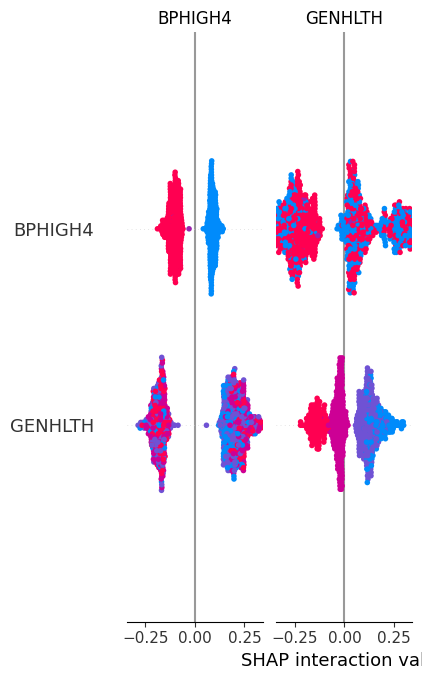

In [9]:
import shap
import numpy as np

# 1) Sample fast subset
X_sample = X_test.sample(1000, random_state=42)

# 2) Fast tree explainer (skip additivity check for speed)
explainer = shap.TreeExplainer(rf_bal)
shap_raw = explainer.shap_values(X_sample, check_additivity=False)

# 3) Normalize shap values to a 2D array matching X_sample
def pick_shap_matrix(shap_out, X):
    # Case A: list of arrays (one per class)
    if isinstance(shap_out, list):
        # For binary classifiers, class 1 is the "positive" class
        arr = shap_out[1] if len(shap_out) > 1 else shap_out[0]
    else:
        # Case B: single ndarray already
        arr = shap_out

    # Some SHAP versions include an extra last column (constant offset)
    if arr.shape[1] == X.shape[1] + 1:
        arr = arr[:, :-1]

    # Sanity check
    assert arr.shape[1] == X.shape[1], f"Still mismatched: SHAP {arr.shape} vs X {X.shape}"
    return arr

shap_vals = pick_shap_matrix(shap_raw, X_sample)

# 4) Plot (global importance / beeswarm)
shap.summary_plot(shap_vals, X_sample)